# <span style="background-color:aquamarine">Supercabs Case Study - Using Architecture-1</span>
### by Hari Krishna Pobbati and Jerry Kappen

# <span style="background-color:greenyellow">Import libraries & instantiate environment</span>
 ***

In [405]:
# Importing libraries
import hashlib
import numpy as np
import time
import random
import math
from collections import deque
import collections
import pickle
import pandas as pd 
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.models import load_model
from shutil import copyfile

# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Import the environment
from Env import CabDriver
env = CabDriver()

## <span style="background-color:yellow">Defining Time Matrix</span>
 ***

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

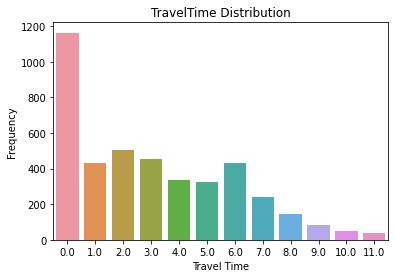

In [3]:
#For information - check the travel time values and distribution
tm=(Time_matrix[:,:,:,:])
tm.resize(5*5*24*7)
df=pd.DataFrame(tm,columns=['TravelTime'])
dfc=df['TravelTime'].value_counts()
sns.barplot(x=dfc.index,y=dfc.values)
plt.title('TravelTime Distribution')
plt.xlabel('Travel Time')
plt.ylabel('Frequency')
plt.show()

## <span style="background-color:yellow">Tracking the state-action pairs for checking convergence</span>
 ***

In [4]:
#Function to encode and decode state array
def encode_track_state(state):
    return ('-'.join(str(e) for e in state))
def decode_track_state(encodedstate):
    return [int(x) for x in encodedstate.split('-')]

In [5]:
#Function to encode and decode action array
def encode_track_action(action):
    return ('-'.join(str(e) for e in action))
def decode_track_action(encodedaction):
    return [int(x) for x in encodedaction.split('-')]

In [6]:
# Tracking q-values for all possible moves from position 4 at the start of the episode
def initialise_tracking_states(episodes):
    global States_track
    States_track={} #initialize
    #Select random 4 states and all action-space for tracking
    sample_q_values = [(y,encode_track_action(r)) 
                     for y,z in [(encode_track_state(x),list(env.action_space)) 
                         for x in random.choices(list(env.state_space),k=4)] for r in z]     
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        if not state in States_track:
            States_track[state]={}
        States_track[state][action] = []

In [7]:
# Function to save q-value for tracking states-action pair
def save_tracking_states(curr_state, curr_action, curr_q_value):
    if curr_state in States_track:
        if curr_action in States_track[curr_state]:
            States_track[curr_state][curr_action].append(curr_q_value)

In [8]:
#Defining a function to save the Q-dictionary as a pickle file. Also used for saving other objects
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# <span style="background-color:greenyellow">Agent Class</span>
 ***
If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.90
        self.learning_rate =  0.01      
        self.epsilon = 1.0
        self.epsilon_decay = -.0005
        self.epsilon_min = 0.00001
               
        self.batch_size = 64     
        self.train_start = 50
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # input layer - input dimension would be state size
        model.add(Dense(64, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # layer - 2
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output size is total number of possible actions     
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        # decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # possible actions list would be given by environment
            choice = random.choice(possible_actions)
        else:
            # choose the action with the highest q(s, a)
            q_values = self.model.predict(state)
            possible_action_q_values = list(q_values[0][index] for index in possible_actions)
            max_q_value = np.max(possible_action_q_values)
            choice = np.where(q_values[0] == max_q_value)
            choice = choice[0][0]
        return choice        
        
    def get_q_values(self, state):
        return self.model.predict(state)[0]       

    def append_sample(self, state, action, reward, next_state,terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, terminal_state))
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # don't start the model training until memory queue is of certain size
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        #batch_size = min(self.batch_size, len(self.memory))
        # pick samples randomly from replay memory (with batch_size) and train the network
        mini_batch = random.sample(self.memory, self.batch_size)
        
        # initialise your input and output batch for training the model
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

            
        for i in range(self.batch_size):
            #state, action, reward, next_state, term_state = mini_batch[i]
            update_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])
                
        # Write your code from here
        # 1. Predict the target from states
        target = self.model.predict(update_input)

        # 2. Get the target for the Q-network
        target_qval = self.model.predict(update_target) 
        #3. Update your 'update_output' and 'update_input' batch
        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])              
                
        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    
    def save(self, name):
        self.model.save_weights(name)
        
    def get_model_weights(self):
        return self.model.get_weights()

In [10]:
#Number of episodes
Episodes = 20000

### DQN block

In [11]:
#Variables and hyper-parameters initialization
scores, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
#Set the decay rate according to episodes
agent.epsilon_decay = -0.0006 if Episodes==10000 else -0.0009
agent.epsilon_decay = -0.00035 if Episodes==15000 else -0.0009
agent.epsilon_decay = -0.00025 if Episodes==20000 else -0.0009
States_track = collections.defaultdict(dict)
initialise_tracking_states(Episodes) # Call function to initialize tracking states

In [12]:
#Execute training
#Variables to check progress of training
start_time = time.time()
lap_start = time.time()
lap_num = -1 
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0 
    current_day = 0
    #env.reset()

    #Reset env
    action_space, state_space, state = env.reset()
    track_state = state
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)
        
        # pick epsilon-greedy action from possible actions for the current state
        # possible actions is given by the environment
        action = agent.get_action(state_encoded)
        
        # evaluate your reward and next state
        reward, totaltime = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix, totaltime)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        # append the experience to the memory
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        # train the model by calling function agent.train_model
        agent.train_model()
        
        # keep track of rewards
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > 30:
            terminal_state = True
            
        # once you reach end of 30 days, scores and episode saved
        if terminal_state == True:
            scores.append(score)
            episodes.append(episode)  
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = (1-agent.epsilon_min)*np.exp(agent.epsilon_decay*episode) 
    
    
    # this is track q-value convergence
    # once the episode is complete, q-values will be predicted for all possible actions for the initial state
    # this way is much easier to track because other states would be difficult to track as it is heavily dependant on the location and action taken
    if (episode + 1) % 50 == 0:
        #We are tracking a handful of states for Q-value convergence
        for track_state_encode in States_track:
            track_state = decode_track_state(track_state_encode)    
            if track_state_encode in States_track: 
                track_state_model_encoded = env.state_encod_arch1(track_state)
                track_state_model_encoded = np.reshape(track_state_model_encoded, [1, state_size])
                track_q_values = agent.get_q_values(track_state_model_encoded) 
                #Save tracking state and action if present in States_track dictionary
                for index in range(len(env.action_space)):
                    track_action_encode = encode_track_action(env.action_space[index])
                    if track_action_encode in States_track[track_state_encode]:
                        States_track[track_state_encode][track_action_encode].append(track_q_values[index])
                    #save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
    
    #save the pickle file
    # Storing the top models as it progresses
    if score >=np.percentile(scores,99) or (episode + 1) % 100 == 0:
        print("Episode:", episode + 1, "  score:", score, "  memory length:", 
              len(agent.memory), "  epsilon:", agent.epsilon, 
              " procrate:", round((time.time()-lap_start)/(episode-lap_num),3)," sec/episode")
        # this is the only one required for assignment. this will create pickle file
        if score >=np.percentile(scores,99):
            agent.model.save(f"cardriver_dqn_model_{'%05d' % episode}_{'%04d' % score}.h5")
            agent.model.save_weights(f"cardriver_dqn_model_weights_{'%05d' % episode}_{'%04d' % score}.h5") 
        #Storing     
        save_obj((agent.memory,scores,episodes,States_track),"cardriver_collections")
        lap_start = time.time()
        lap_num = episode
save_obj((agent.memory,scores,episodes,States_track),"cardriver_collections")
try:
    #Post 75% of the episodes, find the model with the highest score and save it as the selected one
    idx=scores[int(Episodes*0.75):].index(max(scores[int(Episodes*0.75):]))
    episode,score=episodes[int(Episodes*0.75):][idx],scores[int(Episodes*0.75):][idx]  
    copyfile(f"cardriver_dqn_model_{'%05d' % episode}_{'%04d' % score}.h5","cardriver_dqn_model_highestscore.h5")
    copyfile(f"cardriver_dqn_model_weights_{'%05d' % episode}_{'%04d' % score}.h5","cardriver_dqn_model_weights_highestscore.h5")
except Exception as e:
    print('Manually inspect the saved model files with scores.')
print('Elapsed time: ',time.time()-start_time)        

Episode: 1   score: -395.0   memory length: 147   epsilon: 0.99999  procrate: 0.78  sec/episode
Episode: 2   score: 83.0   memory length: 282   epsilon: 0.9997400337470836  procrate: 0.345  sec/episode
Episode: 15   score: 88.0   memory length: 2000   epsilon: 0.9964961527992363  procrate: 0.355  sec/episode
Episode: 39   score: 88.0   memory length: 2000   epsilon: 0.9905350769930761  procrate: 0.392  sec/episode
Episode: 100   score: -329.0   memory length: 2000   epsilon: 0.9755440144496148  procrate: 0.363  sec/episode
Episode: 125   score: 285.0   memory length: 2000   epsilon: 0.9694658783202952  procrate: 0.367  sec/episode
Episode: 126   score: 315.0   memory length: 2000   epsilon: 0.9692235421439994  procrate: 0.392  sec/episode
Episode: 200   score: -24.0   memory length: 2000   epsilon: 0.9514577469126202  procrate: 0.352  sec/episode
Episode: 218   score: 260.0   memory length: 2000   epsilon: 0.9471858061271783  procrate: 0.361  sec/episode
Episode: 266   score: 342.0   m

Episode: 1552   score: 592.0   memory length: 2000   epsilon: 0.6785751817323972  procrate: 0.345  sec/episode
Episode: 1563   score: 684.0   memory length: 2000   epsilon: 0.6767116634946145  procrate: 0.354  sec/episode
Episode: 1573   score: 739.0   memory length: 2000   epsilon: 0.6750219972986573  procrate: 0.364  sec/episode
Episode: 1587   score: 733.0   memory length: 2000   epsilon: 0.6726635499984684  procrate: 0.355  sec/episode
Episode: 1593   score: 851.0   memory length: 2000   epsilon: 0.6716553110417331  procrate: 0.361  sec/episode
Episode: 1594   score: 745.0   memory length: 2000   epsilon: 0.6714874182014522  procrate: 0.317  sec/episode
Episode: 1600   score: 622.0   memory length: 2000   epsilon: 0.6704809421199255  procrate: 0.377  sec/episode
Episode: 1610   score: 631.0   memory length: 2000   epsilon: 0.6688068332726164  procrate: 0.349  sec/episode
Episode: 1621   score: 665.0   memory length: 2000   epsilon: 0.6669701410903658  procrate: 0.349  sec/episode
E

Episode: 2316   score: 841.0   memory length: 2000   epsilon: 0.560593071139752  procrate: 0.343  sec/episode
Episode: 2319   score: 864.0   memory length: 2000   epsilon: 0.5601727839637891  procrate: 0.364  sec/episode
Episode: 2323   score: 823.0   memory length: 2000   epsilon: 0.5596128911728786  procrate: 0.341  sec/episode
Episode: 2329   score: 925.0   memory length: 2000   epsilon: 0.5587741010859576  procrate: 0.326  sec/episode
Episode: 2331   score: 958.0   memory length: 2000   epsilon: 0.5584947838705374  procrate: 0.363  sec/episode
Episode: 2335   score: 908.0   memory length: 2000   epsilon: 0.5579365682409997  procrate: 0.347  sec/episode
Episode: 2336   score: 922.0   memory length: 2000   epsilon: 0.5577971015330043  procrate: 0.345  sec/episode
Episode: 2346   score: 1038.0   memory length: 2000   epsilon: 0.5564043504434248  procrate: 0.357  sec/episode
Episode: 2353   score: 894.0   memory length: 2000   epsilon: 0.5554314943275312  procrate: 0.349  sec/episode
E

Episode: 3006   score: 1021.0   memory length: 2000   epsilon: 0.47177174566810637  procrate: 0.356  sec/episode
Episode: 3014   score: 1068.0   memory length: 2000   epsilon: 0.4708291450915469  procrate: 0.353  sec/episode
Episode: 3032   score: 1256.0   memory length: 2000   epsilon: 0.46871517394104867  procrate: 0.341  sec/episode
Episode: 3033   score: 1021.0   memory length: 2000   epsilon: 0.46859800979369204  procrate: 0.37  sec/episode
Episode: 3037   score: 1261.0   memory length: 2000   epsilon: 0.46812964600482304  procrate: 0.364  sec/episode
Episode: 3041   score: 1236.0   memory length: 2000   epsilon: 0.46766175034563917  procrate: 0.351  sec/episode
Episode: 3045   score: 1161.0   memory length: 2000   epsilon: 0.46719432234824454  procrate: 0.345  sec/episode
Episode: 3074   score: 1123.0   memory length: 2000   epsilon: 0.4638194123427855  procrate: 0.342  sec/episode
Episode: 3076   score: 1215.0   memory length: 2000   epsilon: 0.46358756060437895  procrate: 0.403

Episode: 3780   score: 1362.0   memory length: 2000   epsilon: 0.3887728651741979  procrate: 0.342  sec/episode
Episode: 3782   score: 1293.0   memory length: 2000   epsilon: 0.3885785273301205  procrate: 0.357  sec/episode
Episode: 3784   score: 1228.0   memory length: 2000   epsilon: 0.38838428663067703  procrate: 0.36  sec/episode
Episode: 3800   score: 881.0   memory length: 2000   epsilon: 0.3868338524198211  procrate: 0.336  sec/episode
Episode: 3802   score: 1362.0   memory length: 2000   epsilon: 0.38664048383978467  procrate: 0.333  sec/episode
Episode: 3814   score: 1278.0   memory length: 2000   epsilon: 0.38548230053186455  procrate: 0.332  sec/episode
Episode: 3832   score: 1261.0   memory length: 2000   epsilon: 0.38375152733983203  procrate: 0.349  sec/episode
Episode: 3847   score: 1197.0   memory length: 2000   epsilon: 0.38231515399557775  procrate: 0.354  sec/episode
Episode: 3878   score: 1249.0   memory length: 2000   epsilon: 0.37936366335116983  procrate: 0.341  

Episode: 4500   score: 1006.0   memory length: 2000   epsilon: 0.32473039328501824  procrate: 0.385  sec/episode
Episode: 4505   score: 1303.0   memory length: 2000   epsilon: 0.32432473388335814  procrate: 0.35  sec/episode
Episode: 4518   score: 1288.0   memory length: 2000   epsilon: 0.32327238948416814  procrate: 0.355  sec/episode
Episode: 4519   score: 1362.0   memory length: 2000   epsilon: 0.32319158148821747  procrate: 0.329  sec/episode
Episode: 4520   score: 1388.0   memory length: 2000   epsilon: 0.3231107936917407  procrate: 0.349  sec/episode
Episode: 4521   score: 1367.0   memory length: 2000   epsilon: 0.32303002608968867  procrate: 0.393  sec/episode
Episode: 4522   score: 1509.0   memory length: 2000   epsilon: 0.32294927867701345  procrate: 0.356  sec/episode
Episode: 4525   score: 1323.0   memory length: 2000   epsilon: 0.32270715752478724  procrate: 0.344  sec/episode
Episode: 4531   score: 1399.0   memory length: 2000   epsilon: 0.32222345965259747  procrate: 0.35

Episode: 5112   score: 1439.0   memory length: 2000   epsilon: 0.27866080205337723  procrate: 0.351  sec/episode
Episode: 5114   score: 1368.0   memory length: 2000   epsilon: 0.27852150647914603  procrate: 0.346  sec/episode
Episode: 5118   score: 1422.0   memory length: 2000   epsilon: 0.2782431241870115  procrate: 0.342  sec/episode
Episode: 5121   score: 1532.0   memory length: 2000   epsilon: 0.27803452008018964  procrate: 0.334  sec/episode
Episode: 5136   score: 1450.0   memory length: 2000   epsilon: 0.27699384311873465  procrate: 0.343  sec/episode
Episode: 5137   score: 1383.0   memory length: 2000   epsilon: 0.2769246033132913  procrate: 0.389  sec/episode
Episode: 5146   score: 1396.0   memory length: 2000   epsilon: 0.27630222339581  procrate: 0.362  sec/episode
Episode: 5175   score: 1392.0   memory length: 2000   epsilon: 0.27430627632697124  procrate: 0.346  sec/episode
Episode: 5180   score: 1378.0   memory length: 2000   epsilon: 0.2739636076940764  procrate: 0.365  s

Episode: 5858   score: 1477.0   memory length: 2000   epsilon: 0.23124905246422425  procrate: 0.342  sec/episode
Episode: 5863   score: 1473.0   memory length: 2000   epsilon: 0.23096017173671335  procrate: 0.364  sec/episode
Episode: 5899   score: 1550.0   memory length: 2000   epsilon: 0.22889085607940265  procrate: 0.351  sec/episode
Episode: 5900   score: 832.0   memory length: 2000   epsilon: 0.22883364051762603  procrate: 0.331  sec/episode
Episode: 5939   score: 1465.0   memory length: 2000   epsilon: 0.22661335400811736  procrate: 0.447  sec/episode
Episode: 5947   score: 1613.0   memory length: 2000   epsilon: 0.22616058022480903  procrate: 0.438  sec/episode
Episode: 5960   score: 1525.0   memory length: 2000   epsilon: 0.22542675145674854  procrate: 0.385  sec/episode
Episode: 5971   score: 1516.0   memory length: 2000   epsilon: 0.22480767950432137  procrate: 0.372  sec/episode
Episode: 5972   score: 1706.0   memory length: 2000   epsilon: 0.22475148460909986  procrate: 0.3

Episode: 6584   score: 1581.0   memory length: 2000   epsilon: 0.1928659289643046  procrate: 0.347  sec/episode
Episode: 6600   score: 1011.0   memory length: 2000   epsilon: 0.1920960061206981  procrate: 0.351  sec/episode
Episode: 6618   score: 1540.0   memory length: 2000   epsilon: 0.19123351615103806  procrate: 0.343  sec/episode
Episode: 6620   score: 1554.0   memory length: 2000   epsilon: 0.19113792329316853  procrate: 0.354  sec/episode
Episode: 6642   score: 1661.0   memory length: 2000   epsilon: 0.1900895503833302  procrate: 0.335  sec/episode
Episode: 6644   score: 1581.0   memory length: 2000   epsilon: 0.18999452936537262  procrate: 0.371  sec/episode
Episode: 6653   score: 1576.0   memory length: 2000   epsilon: 0.18956752223746304  procrate: 0.346  sec/episode
Episode: 6700   score: 1355.0   memory length: 2000   epsilon: 0.18735313883057214  procrate: 0.351  sec/episode
Episode: 6710   score: 1636.0   memory length: 2000   epsilon: 0.1868853409744605  procrate: 0.353 

Episode: 7454   score: 1622.0   memory length: 2000   epsilon: 0.1551659639002896  procrate: 0.354  sec/episode
Episode: 7469   score: 1601.0   memory length: 2000   epsilon: 0.15458518118386144  procrate: 0.334  sec/episode
Episode: 7487   score: 1603.0   memory length: 2000   epsilon: 0.15389111069836997  procrate: 0.347  sec/episode
Episode: 7500   score: 1317.0   memory length: 2000   epsilon: 0.153391776446278  procrate: 0.369  sec/episode
Episode: 7514   score: 1718.0   memory length: 2000   epsilon: 0.15285584365819313  procrate: 0.335  sec/episode
Episode: 7532   score: 1702.0   memory length: 2000   epsilon: 0.1521695377082595  procrate: 0.35  sec/episode
Episode: 7540   score: 1611.0   memory length: 2000   epsilon: 0.15186550276912708  procrate: 0.336  sec/episode
Episode: 7547   score: 1643.0   memory length: 2000   epsilon: 0.15159997054774085  procrate: 0.375  sec/episode
Episode: 7553   score: 1683.0   memory length: 2000   epsilon: 0.1513727410566431  procrate: 0.352  s

Episode: 8200   score: 1381.0   memory length: 2000   epsilon: 0.1287658036660888  procrate: 0.361  sec/episode
Episode: 8228   score: 1654.0   memory length: 2000   epsilon: 0.12786759045436816  procrate: 0.354  sec/episode
Episode: 8239   score: 1728.0   memory length: 2000   epsilon: 0.1275164376370419  procrate: 0.351  sec/episode
Episode: 8250   score: 1701.0   memory length: 2000   epsilon: 0.12716624916338293  procrate: 0.343  sec/episode
Episode: 8257   score: 1676.0   memory length: 2000   epsilon: 0.12694390283712714  procrate: 0.351  sec/episode
Episode: 8263   score: 1829.0   memory length: 2000   epsilon: 0.12675362972338294  procrate: 0.347  sec/episode
Episode: 8266   score: 1757.0   memory length: 2000   epsilon: 0.1266586001416381  procrate: 0.353  sec/episode
Episode: 8283   score: 1690.0   memory length: 2000   epsilon: 0.12612144335773456  procrate: 0.35  sec/episode
Episode: 8284   score: 1672.0   memory length: 2000   epsilon: 0.12608991693786184  procrate: 0.351 

Episode: 8958   score: 1762.0   memory length: 2000   epsilon: 0.10653731282269631  procrate: 0.347  sec/episode
Episode: 8967   score: 1834.0   memory length: 2000   epsilon: 0.10629787333927765  procrate: 0.354  sec/episode
Episode: 8983   score: 1737.0   memory length: 2000   epsilon: 0.10587353109619621  procrate: 0.347  sec/episode
Episode: 8985   score: 1731.0   memory length: 2000   epsilon: 0.10582060756263406  procrate: 0.369  sec/episode
Episode: 8997   score: 1845.0   memory length: 2000   epsilon: 0.10550362145684436  procrate: 0.35  sec/episode
Episode: 8999   score: 1755.0   memory length: 2000   epsilon: 0.10545088283187094  procrate: 0.352  sec/episode
Episode: 9000   score: 1377.0   memory length: 2000   epsilon: 0.10542452340622845  procrate: 0.372  sec/episode
Episode: 9002   score: 1706.0   memory length: 2000   epsilon: 0.10537182432039471  procrate: 0.359  sec/episode
Episode: 9026   score: 1730.0   memory length: 2000   epsilon: 0.10474148627960767  procrate: 0.3

Episode: 9740   score: 1841.0   memory length: 2000   epsilon: 0.08761877302598514  procrate: 0.35  sec/episode
Episode: 9744   score: 1749.0   memory length: 2000   epsilon: 0.08753119804774619  procrate: 0.349  sec/episode
Episode: 9749   score: 1768.0   memory length: 2000   epsilon: 0.08742185240545068  procrate: 0.362  sec/episode
Episode: 9755   score: 1793.0   memory length: 2000   epsilon: 0.0872908179272701  procrate: 0.34  sec/episode
Episode: 9757   score: 1862.0   memory length: 2000   epsilon: 0.08724718342784037  procrate: 0.34  sec/episode
Episode: 9761   score: 1770.0   memory length: 2000   epsilon: 0.08715997985346668  procrate: 0.365  sec/episode
Episode: 9762   score: 1855.0   memory length: 2000   epsilon: 0.0871381925820257  procrate: 0.358  sec/episode
Episode: 9765   score: 1752.0   memory length: 2000   epsilon: 0.08707286343908012  procrate: 0.379  sec/episode
Episode: 9769   score: 1933.0   memory length: 2000   epsilon: 0.0869858340975642  procrate: 0.329  s

Episode: 10621   score: 1789.0   memory length: 2000   epsilon: 0.07029813567684179  procrate: 0.348  sec/episode
Episode: 10675   score: 1875.0   memory length: 2000   epsilon: 0.06935548803321652  procrate: 0.348  sec/episode
Episode: 10684   score: 1861.0   memory length: 2000   epsilon: 0.06919961360962784  procrate: 0.368  sec/episode
Episode: 10700   score: 1633.0   memory length: 2000   epsilon: 0.06892336801470654  procrate: 0.358  sec/episode
Episode: 10703   score: 1840.0   memory length: 2000   epsilon: 0.06887169486854748  procrate: 0.359  sec/episode
Episode: 10727   score: 1780.0   memory length: 2000   epsilon: 0.06845970191417741  procrate: 0.365  sec/episode
Episode: 10737   score: 1904.0   memory length: 2000   epsilon: 0.06828876641779136  procrate: 0.364  sec/episode
Episode: 10750   score: 1851.0   memory length: 2000   epsilon: 0.0680671881865942  procrate: 0.35  sec/episode
Episode: 10760   score: 1831.0   memory length: 2000   epsilon: 0.06789723274894323  procr

Episode: 11634   score: 1830.0   memory length: 2000   epsilon: 0.054570600149644294  procrate: 0.351  sec/episode
Episode: 11638   score: 1878.0   memory length: 2000   epsilon: 0.0545160568257019  procrate: 0.357  sec/episode
Episode: 11644   score: 1845.0   memory length: 2000   epsilon: 0.05443434404037349  procrate: 0.352  sec/episode
Episode: 11657   score: 2002.0   memory length: 2000   epsilon: 0.054257719592436464  procrate: 0.363  sec/episode
Episode: 11658   score: 1887.0   memory length: 2000   epsilon: 0.05424415685795081  procrate: 0.38  sec/episode
Episode: 11690   score: 1892.0   memory length: 2000   epsilon: 0.05381193479651482  procrate: 0.359  sec/episode
Episode: 11700   score: 1450.0   memory length: 2000   epsilon: 0.053677572981772066  procrate: 0.364  sec/episode
Episode: 11724   score: 1829.0   memory length: 2000   epsilon: 0.05335647181069758  procrate: 0.355  sec/episode
Episode: 11742   score: 1835.0   memory length: 2000   epsilon: 0.053116907112385946  p

Episode: 12584   score: 1834.0   memory length: 2000   epsilon: 0.04303420561698098  procrate: 0.356  sec/episode
Episode: 12600   score: 1554.0   memory length: 2000   epsilon: 0.04286241260958512  procrate: 0.363  sec/episode
Episode: 12606   score: 1842.0   memory length: 2000   epsilon: 0.04279816718678386  procrate: 0.352  sec/episode
Episode: 12615   score: 1876.0   memory length: 2000   epsilon: 0.04270197956227032  procrate: 0.347  sec/episode
Episode: 12625   score: 1827.0   memory length: 2000   epsilon: 0.04259535794591718  procrate: 0.355  sec/episode
Episode: 12628   score: 2032.0   memory length: 2000   epsilon: 0.04256342340440774  procrate: 0.359  sec/episode
Episode: 12657   score: 1861.0   memory length: 2000   epsilon: 0.04225595450625823  procrate: 0.351  sec/episode
Episode: 12700   score: 1356.0   memory length: 2000   epsilon: 0.04180413587157657  procrate: 0.354  sec/episode
Episode: 12720   score: 1830.0   memory length: 2000   epsilon: 0.04159563687408515  pro

Episode: 13587   score: 1863.0   memory length: 2000   epsilon: 0.03348994615234381  procrate: 0.344  sec/episode
Episode: 13600   score: 1665.0   memory length: 2000   epsilon: 0.03338128050467455  procrate: 0.35  sec/episode
Episode: 13609   score: 2058.0   memory length: 2000   epsilon: 0.03330625705656867  procrate: 0.372  sec/episode
Episode: 13611   score: 1950.0   memory length: 2000   epsilon: 0.03328960809062873  procrate: 0.344  sec/episode
Episode: 13613   score: 1935.0   memory length: 2000   epsilon: 0.033272967447090976  procrate: 0.346  sec/episode
Episode: 13614   score: 1922.0   memory length: 2000   epsilon: 0.0332646502449228  procrate: 0.398  sec/episode
Episode: 13621   score: 1998.0   memory length: 2000   epsilon: 0.0332064880137899  procrate: 0.372  sec/episode
Episode: 13629   score: 1864.0   memory length: 2000   epsilon: 0.03314014140648516  procrate: 0.358  sec/episode
Episode: 13690   score: 1859.0   memory length: 2000   epsilon: 0.03263858831254335  procr

Episode: 14432   score: 1989.0   memory length: 2000   epsilon: 0.027112510920351735  procrate: 0.349  sec/episode
Episode: 14442   score: 1985.0   memory length: 2000   epsilon: 0.027044814299086093  procrate: 0.348  sec/episode
Episode: 14453   score: 1901.0   memory length: 2000   epsilon: 0.026970543229290822  procrate: 0.351  sec/episode
Episode: 14455   score: 1927.0   memory length: 2000   epsilon: 0.026957061328432258  procrate: 0.376  sec/episode
Episode: 14465   score: 1883.0   memory length: 2000   epsilon: 0.026889752845771005  procrate: 0.35  sec/episode
Episode: 14470   score: 1904.0   memory length: 2000   epsilon: 0.026856161653582764  procrate: 0.366  sec/episode
Episode: 14490   score: 1920.0   memory length: 2000   epsilon: 0.026722215988530824  procrate: 0.375  sec/episode
Episode: 14495   score: 1959.0   memory length: 2000   epsilon: 0.02668883408658049  procrate: 0.36  sec/episode
Episode: 14500   score: 1599.0   memory length: 2000   epsilon: 0.02665549388593883

Episode: 15135   score: 2042.0   memory length: 2000   epsilon: 0.02274272420162927  procrate: 0.486  sec/episode
Episode: 15140   score: 1996.0   memory length: 2000   epsilon: 0.022714313556729593  procrate: 0.455  sec/episode
Episode: 15200   score: 1533.0   memory length: 2000   epsilon: 0.022376141484622036  procrate: 0.375  sec/episode
Episode: 15211   score: 2016.0   memory length: 2000   epsilon: 0.022314691627818635  procrate: 0.367  sec/episode
Episode: 15215   score: 1982.0   memory length: 2000   epsilon: 0.022292388089818444  procrate: 0.382  sec/episode
Episode: 15218   score: 1984.0   memory length: 2000   epsilon: 0.022275675066918094  procrate: 0.355  sec/episode
Episode: 15224   score: 1933.0   memory length: 2000   epsilon: 0.022242286601926793  procrate: 0.377  sec/episode
Episode: 15235   score: 1919.0   memory length: 2000   epsilon: 0.02218120434037568  procrate: 0.368  sec/episode
Episode: 15255   score: 1914.0   memory length: 2000   epsilon: 0.0220705751221966

Episode: 16256   score: 1929.0   memory length: 2000   epsilon: 0.017184284579804456  procrate: 0.38  sec/episode
Episode: 16265   score: 1967.0   memory length: 2000   epsilon: 0.017145663404615288  procrate: 0.373  sec/episode
Episode: 16281   score: 2041.0   memory length: 2000   epsilon: 0.017077217733599718  procrate: 0.389  sec/episode
Episode: 16300   score: 1979.0   memory length: 2000   epsilon: 0.016996293297056663  procrate: 0.364  sec/episode
Episode: 16301   score: 2170.0   memory length: 2000   epsilon: 0.016992044754822296  procrate: 0.345  sec/episode
Episode: 16344   score: 1966.0   memory length: 2000   epsilon: 0.016810358586534787  procrate: 0.368  sec/episode
Episode: 16358   score: 1986.0   memory length: 2000   epsilon: 0.01675162517490928  procrate: 0.354  sec/episode
Episode: 16391   score: 2220.0   memory length: 2000   epsilon: 0.016613992781472044  procrate: 0.365  sec/episode
Episode: 16400   score: 1632.0   memory length: 2000   epsilon: 0.0165766533203600

Episode: 17404   score: 1936.0   memory length: 2000   epsilon: 0.01289700712881721  procrate: 0.382  sec/episode
Episode: 17411   score: 2029.0   memory length: 2000   epsilon: 0.012874457103368996  procrate: 0.371  sec/episode
Episode: 17412   score: 2066.0   memory length: 2000   epsilon: 0.01287123889138641  procrate: 0.548  sec/episode
Episode: 17427   score: 1936.0   memory length: 2000   epsilon: 0.012823062133422018  procrate: 0.38  sec/episode
Episode: 17473   score: 1977.0   memory length: 2000   epsilon: 0.012676441602815523  procrate: 0.364  sec/episode
Episode: 17487   score: 1941.0   memory length: 2000   epsilon: 0.012632151609905955  procrate: 0.371  sec/episode
Episode: 17500   score: 1788.0   memory length: 2000   epsilon: 0.012591163758510127  procrate: 0.377  sec/episode
Episode: 17502   score: 1966.0   memory length: 2000   epsilon: 0.012584869750264049  procrate: 0.354  sec/episode
Episode: 17516   score: 1982.0   memory length: 2000   epsilon: 0.0125408996986146 

Episode: 18304   score: 1960.0   memory length: 2000   epsilon: 0.010298469365815842  procrate: 0.359  sec/episode
Episode: 18312   score: 2015.0   memory length: 2000   epsilon: 0.010277893010298515  procrate: 0.384  sec/episode
Episode: 18320   score: 2044.0   memory length: 2000   epsilon: 0.010257357766366933  procrate: 0.379  sec/episode
Episode: 18386   score: 1980.0   memory length: 2000   epsilon: 0.010089499998066192  procrate: 0.371  sec/episode
Episode: 18400   score: 1854.0   memory length: 2000   epsilon: 0.010054248474225607  procrate: 0.369  sec/episode
Episode: 18404   score: 1980.0   memory length: 2000   epsilon: 0.010044199251200333  procrate: 0.399  sec/episode
Episode: 18412   score: 1971.0   memory length: 2000   epsilon: 0.010024130927710857  procrate: 0.356  sec/episode
Episode: 18464   score: 2027.0   memory length: 2000   epsilon: 0.009894660606109584  procrate: 0.369  sec/episode
Episode: 18469   score: 1983.0   memory length: 2000   epsilon: 0.00988230000733

Episode: 19432   score: 2028.0   memory length: 2000   epsilon: 0.007767864433605059  procrate: 0.364  sec/episode
Episode: 19453   score: 2045.0   memory length: 2000   epsilon: 0.007727190009116938  procrate: 0.378  sec/episode
Episode: 19463   score: 2036.0   memory length: 2000   epsilon: 0.007707896161452608  procrate: 0.369  sec/episode
Episode: 19485   score: 2008.0   memory length: 2000   epsilon: 0.007665619101054081  procrate: 0.384  sec/episode
Episode: 19486   score: 2025.0   memory length: 2000   epsilon: 0.007663702935809457  procrate: 0.347  sec/episode
Episode: 19500   score: 1820.0   memory length: 2000   epsilon: 0.007636926860998947  procrate: 0.371  sec/episode
Episode: 19510   score: 1984.0   memory length: 2000   epsilon: 0.007617858389367482  procrate: 0.395  sec/episode
Episode: 19537   score: 1999.0   memory length: 2000   epsilon: 0.007566610999758963  procrate: 0.375  sec/episode
Episode: 19559   score: 2068.0   memory length: 2000   epsilon: 0.00752510887472

In [407]:
#Check the selected and copied model for manual verification
idx=scores[int(Episodes*0.75):].index(max(scores[int(Episodes*0.75):]))
episode,score=episodes[int(Episodes*0.75):][idx],scores[int(Episodes*0.75):][idx] 
print(f'Selected model is for episode {episode} with a score of {score}')

Selected model is for episode 16390 with a score of 2220.0


# <span style="background-color:greenyellow">Load saved model and collections of data</span>
 ***

In [13]:
#Load saved model and saved collections
l_env = CabDriver()
l_agent = DQNAgent(state_size, action_size)
l_agent.model = load_model("cardriver_dqn_model_highestscore.h5")
l_agent.memory,l_scores,l_episodes,l_States_track = pickle.load( open( "cardriver_collections.pkl", "rb" ))

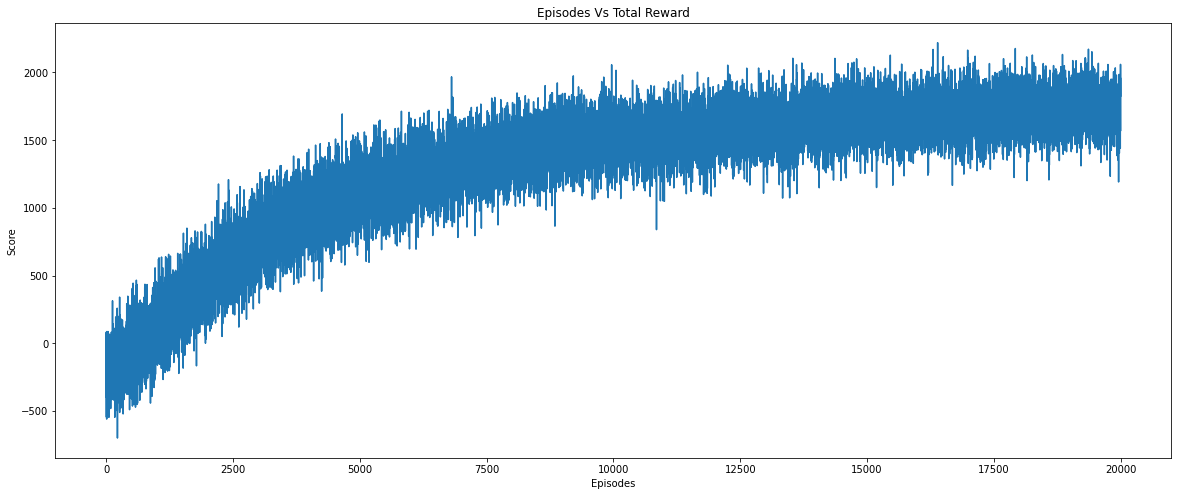

In [14]:
#Plot total rewards against episodes
plt.figure(figsize=(20,8))
plt.plot(range(len(l_scores)),l_scores)
plt.title('Episodes Vs Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

# <span style="background-color:greenyellow">Tracking Convergence</span>
 ***

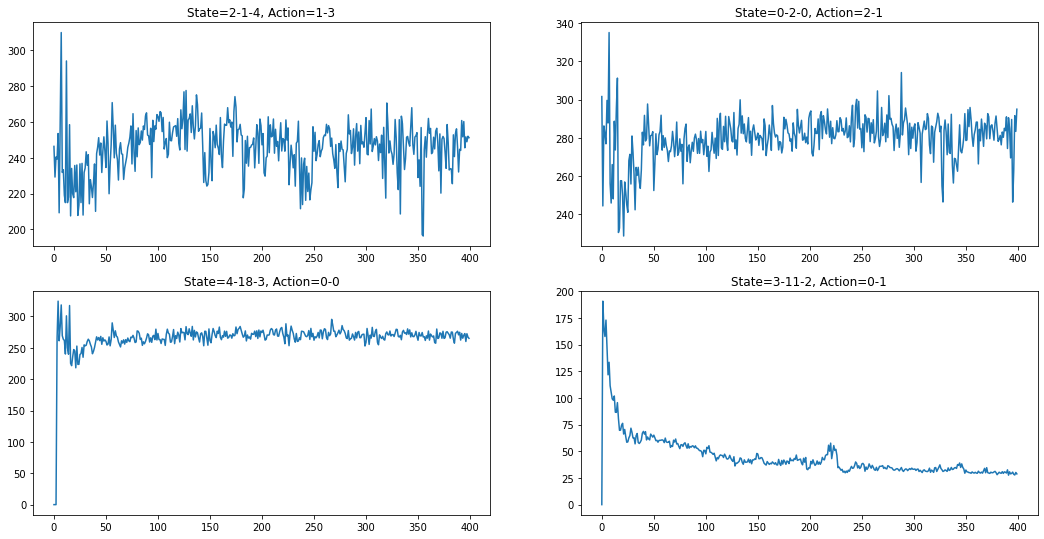

In [97]:
#There are 4 states tracked and all actions in each state. Pick random action in each state based on
#range of variation.
rand_track={x: l_States_track[x] for x in l_States_track if len(l_States_track[x])>0}
ss={}
for x in rand_track:
    rand_act=random.choice(list(rand_track[x].keys()))
    #ss[x]={rand_act:rand_track[x][rand_act]}
    ll=[]
    for y in rand_track[x]:
        if max((rand_track[x][y])[10:])-min((rand_track[x][y])[10:])>50:
            ll.append({y:rand_track[x][y]})
        ss[x]=random.choice(ll)
#Generate plots
fs=max(int(len(list(ss.keys()))/3),1)
plt.figure(figsize=(18,14))
c=0
for k in ss.keys():
    for j in ss[k].keys():
        c+=1
        plt.subplot(fs+2,2,c)
        plt.plot(range(len(States_track[k][j])),States_track[k][j])
        plt.title(f'State={k}, Action={j}')
plt.show()

# <span style="background-color:greenyellow">Test The Model</span>
 ***

In [399]:
#For the same initial state, use the model to predict and choose action based on highest Q-value
#For the same initial state, use a random selection of action
#Compare the two for 30 days of running the cab
print('############ Testing Model Versus Random Choice Score (30 days in each round) ############')
for i in range(25):
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state, score, reward,total_days,previous_day,current_day = False,0,0,1,0,0
    #Call the DQN agent
    action_space, state_space, state = l_env.reset()
    init_state=state # Save the initial state for the next block of random-based test
    #Model based score for 30 days
    while not terminal_state:
        state_encoded = l_env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        # get possible list of actions from the environment
        possible_actions, action_list = l_env.requests(state)
        #Get the action with the max q-value per the model
        q_values = l_agent.model.predict(state_encoded)
        possible_action_q_values = list(q_values[0][index] for index in possible_actions)
        max_q_value = np.max(possible_action_q_values)
        choice = np.where(q_values[0] == max_q_value)
        action = choice[0][0]
        # evaluate your reward and next state
        reward, totaltime = l_env.reward_func(state, l_env.action_space[action], Time_matrix)
        next_state = l_env.next_state_func(state, l_env.action_space[action], Time_matrix, totaltime)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        # keep track of rewards
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
        if total_days > 30:
            terminal_state = True
    model_score=score # Store model-score for 30 days
    terminal_state, score, reward,total_days,previous_day,current_day = False,0,0,1,0,0
    l_env.reset()
    #Set the same inital state as for the model
    state,l_env.state_init=init_state,init_state
    #Random choice based score for 30 days
    while not terminal_state:
        # get possible list of actions from the environment
        possible_actions, action_list = l_env.requests(state)
        #Choose random action
        action = random.choice(possible_actions)
        # evaluate your reward and next state
        reward, totaltime = l_env.reward_func(state, l_env.action_space[action], Time_matrix)
        next_state = l_env.next_state_func(state, l_env.action_space[action], Time_matrix, totaltime)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        # keep track of rewards
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
        if total_days > 30:
            terminal_state = True
    random_score=score        
    print(f'Round# {"%2d" % (i+1)}, Starting state: {state},Model-based score: {model_score}, Random-based score: {random_score}')            

############ Testing Model Versus Random Choice Score (30 days in each round) ############
Round#  1, Starting state: [4, 5, 4],Model-based score: 1312.0, Random-based score: -390.0
Round#  2, Starting state: [1, 3, 1],Model-based score: 1658.0, Random-based score: 122.0
Round#  3, Starting state: [4, 3, 6],Model-based score: 1792.0, Random-based score: -297.0
Round#  4, Starting state: [0, 1, 2],Model-based score: 1744.0, Random-based score: -214.0
Round#  5, Starting state: [1, 0, 3],Model-based score: 1485.0, Random-based score: -396.0
Round#  6, Starting state: [0, 1, 0],Model-based score: 1739.0, Random-based score: -76.0
Round#  7, Starting state: [1, 4, 0],Model-based score: 1679.0, Random-based score: -376.0
Round#  8, Starting state: [3, 1, 6],Model-based score: 1463.0, Random-based score: -49.0
Round#  9, Starting state: [0, 4, 5],Model-based score: 1872.0, Random-based score: -254.0
Round# 10, Starting state: [0, 1, 1],Model-based score: 1727.0, Random-based score: -289.0
Ro

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

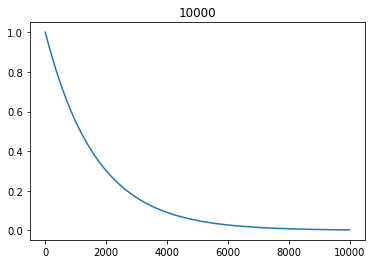

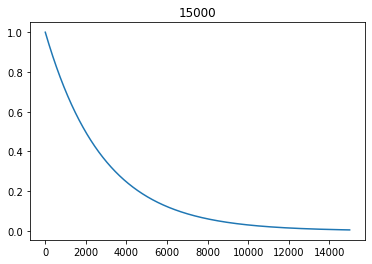

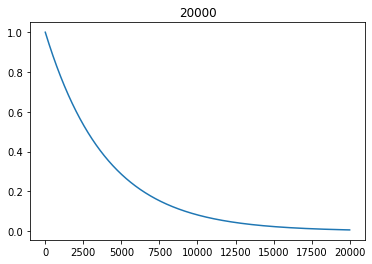

In [61]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append((1-0.00001)*np.exp(-0.0006*i))
plt.plot(time, epsilon)
plt.title('10000')
plt.show()    

time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1-0.00001)*np.exp(-0.00035*i))
plt.plot(time, epsilon)
plt.title('15000')
plt.show()    


time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append((1-0.00001)*np.exp(-0.00025*i))
plt.plot(time, epsilon)
plt.title('20000')
plt.show()    